In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from tensorflow import keras
import sys
from glob import glob
from scipy import stats

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../')
sys.path.append('../..')
import datatools
import importlib

In [4]:
#norm is normalization for std, it is the std of the chi2 fit
norm_a = 0.43
norm_x = 0.102

## Load Data

In [5]:
import config
#SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/20220912/SIG_atlas_nsw_pad_z0_xya/"
DATA_LOC=config.DATA_LOC_VALIDATE

files=glob(f"{DATA_LOC}")

print(len(files))

148


In [6]:
DATA_LOC

'/Data/ML/si-mu-lator/simulation_data/atlas_nsw_pad_z0_bkgr_1/VALIDATE/*.h5'

In [7]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=200, sort_by='z')

 24%|██▎       | 35/148 [00:00<00:00, 346.61it/s]

~~ Reading data... ~~


  2%|▏         | 5603/370000 [00:00<00:06, 56022.84it/s]

~~ Calculating occupancy information... ~~


100%|██████████| 370000/370000 [00:06<00:00, 55316.52it/s]

!!
I read 370000 events, of which 175000 have muon and 195000 do not
!!


In [8]:
sig_keys

['is_muon',
 'x',
 'y',
 'z',
 'ptype',
 'ptilt',
 'poffset',
 'time',
 'projX_at_rightend_x',
 'projX_at_rightend_y',
 'projX_at_middle_x',
 'projX_at_middle_y',
 'projY_at_topend_x',
 'projY_at_topend_y',
 'projY_at_middle_x',
 'projY_at_middle_y',
 'seg_ix',
 'rdrift']

In [9]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'ev_n_noise', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv', 'n_sig_mm', 'n_sig_stgc', 'n_sig_mdt'])

In [10]:
data['ev_n_noise'] = data['ev_n_signals'] - data['ev_n_mu_signals']

# Understand the data

## Define models to compare

In [11]:
import trainingvariables
detmat=config.DET
X_det = datatools.detector_matrix_2(dmat, sig_keys, detcard=detmat)

~~ Preparing detector-based data matrix ~~
Using detector card: /afs/cern.ch/user/r/rrojas/public/ML/r-dev-branch/si-mu-lator/cards/atlas_nsw_pad_z0.yml


  1%|          | 1874/370000 [00:00<00:39, 9343.66it/s]

[0, 5.1, 21.9, 27.0, 92.0, 103.5, 125.2, 125.2, 136.6, 136.6, 223.0, 223.0, 234.5, 234.5, 256.2, 267.6, 334.0, 339.1, 355.9, 361.0]


100%|██████████| 370000/370000 [00:43<00:00, 8412.39it/s]

Output data matrix shape: (370000, 20, 20)


In [12]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

linearized = True

In [13]:
dmat1 = dmat[8000:8001,:,:]

In [14]:
import linefit
lfits = linefit.get_fits(dmat, sig_keys)

../linefit.py:73: RuntimeWarning: invalid value encountered in double_scalars
  A = ( _c5*_c2 - _c3*_c4 ) / ( _c2**2 - _c1*_c4 )
../linefit.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  A = ( _c5*_c2 - _c3*_c4 ) / ( _c2**2 - _c1*_c4 )
../linefit.py:77: RuntimeWarning: invalid value encountered in add
  Chi2 = ( ( A*zs + B - xs )**2 / unc_xs**2 ).sum()


In [15]:
lfits_mu = linefit.get_fits(dmat, sig_keys, is_perfect=True)

In [16]:
lfits_theta = np.arctan(lfits[:,0])*1000
lfits_mu_theta = np.arctan(lfits_mu[:,0])*1000

In [17]:
lfits

array([[-3.13599562e-02, -1.06967638e+00,  3.90472781e+03],
       [ 1.35799488e-02, -8.99989087e-01,  6.43991136e+03],
       [ 2.10802288e-03,  8.32942827e+00,  2.39200016e+03],
       ...,
       [-2.26149973e-02,  1.04801826e+00,  1.28079783e+03],
       [-1.31325632e-02,  2.94645650e+00,  2.42713975e+03],
       [-7.29486486e-03, -1.64085739e+00,  2.05387015e+03]])

In [18]:
lfits_theta

array([-31.34968199,  13.57911406,   2.10801975, ..., -22.61114306,
       -13.13180831,  -7.29473546])

## models list

In [19]:
mod_list = [

#["01",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_4Outputs_LONG_run01"],
#["02",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_4Outputs_LONG_run01"],
#["03",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_4Outputs_LONG_run01"],
#["04",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_4Outputs_LONG_run01"],
#["05",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_4Outputs_LONG"],
#["06",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_4Outputs_LONG"],
#["c1n1_07",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_4Outputs_LONG"],
#["08",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_4Outputs_LONG"],
#["09",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_4Outputs_LONG"],
#["c1n1_10",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_c1n1_4Outputs_LONG"],   
#["11",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_4Outputs_LONG"],
#["c1n1_12",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_c1n1_4Outputs_LONG"],
#["c1n1_13",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_c1n1_4Outputs_LONG"],
    
#["pc02_14",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run03"],
#["pc02_15",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run03"],
#["pc02_16",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run03"],
#["pc02_17",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run03"],
#["c1n1_18",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_c1n1_4Outputs_LONG"],
#["c1n1_19",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_c1n1_4Outputs_LONG"],


#["pc02_20",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run04"],
#["pc02_21",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run04"],
#["pc02_22",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run04"],
#["pc02_23",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run04"],

#["c1n2_24",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_c1n2_4Outputs_LONG"],
#["c1n2_25",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_c1n2_4Outputs_LONG"],
#["c1n2_26",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_c1n2_4Outputs_LONG"],
#["c1n2_27",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_c1n2_4Outputs_LONG"],
    
#["pc02_28",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run06"],
#["pc02_29",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run06"],
#["pc02_30",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run06"],
#["pc02_31",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penFalse_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run06"],

#["pc02_32",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run08"],
#["pc02_33",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run08"],
#["pc02_34",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run08"],
#["pc02_35",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0100_DetMat_pc02_4Outputs_LONG_run08"],

#["pc02_36",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run09"],
#["pc02_37",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run09"],
#["pc02_38",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run09"],
#["pc02_39",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run09"],

#["pc02_40",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run10"],
#["pc02_41",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run10"],
#["pc02_42",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run10"],
#["pc02_43",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run10"],

#["pc02_44",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run11"],
#["pc02_45",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run11"],
#["pc02_46",  "../models/MyTCN_CL25.3.1.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run11"],
#["pc02_47",  "../models/MyTCN_CL25.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run11"],

#["pc02_48",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG"],
#    ["pc02_49",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG"],
#["pc02_50",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run13"],
#["pc02_51",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run13"],
#["pc02_52",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_2_4Outputs_LONG_BIG"],
#["pc02_53",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_nobkg_4Outputs_LONG"],
#["large",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run11"],
#["medium",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run13"],
#["small",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run15"],
#["small_dist",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_2_4Outputs_LONG_BIG_run15"],
#["small_nobkg",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_nobkg_4Outputs_LONG_run15"],

#["large_2",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run16"],
#["large_3",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0010_DetMat_pc02_4Outputs_LONG_run17"],
["large_4",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run18"],
["medium_dist_4",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_BIG_run19"],
["small_dist_4",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_BIG_run19"],
["medium_5",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run20"],
["small_5",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run20"],
["medium_6",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run21"],
["small_6",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run21"],
["small_dist_7",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_BIG_run23"],
["large_8",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run24"],

    
#["small_nobn_9",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run22"],

#["run25",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run25"],
 ["run26",  "../models/MyTCN_CL4.4.4.0..4.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run26"],
#  ["run27",  "../models/QKeras.b14_QKeras.i10_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run27"],
#["run28_small",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run28"],
#["run28_medium",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run28"],
#["run29_qkeras",  "../models/QKeras.b16_QKeras.i2_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run29"],
#["run30_qkeras",  "../models/QKeras.b16_QKeras.i2_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run30"],
#["run31_qkeras",  "../models/QKeras.b16_QKeras.i2_MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run31"],
["run36_large",  "../models/MyTCN_CL7.1.1.0..5.3.1.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run36"],
["run36_medium",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormTrue_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_PRUNED50_run36"],
    #["m_nobn_7",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DL20_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run22"],
#["s_nobn_7",  "../models/MyTCN_CL4.3.1.0..4.3.3.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_penTrue_ptype0_regBiasTrue_lrate0.001_Flatten_L1R0.0005_DetMat_pc02_4Outputs_LONG_run22"],
]
mdict = {}

print ("INFO: Flatten and DetMat assumed unless noted")
for imod,mod in enumerate(mod_list):
    
    m_name = str(imod)+'_'+str(mod[0]) 
    m_name += '' if 'Flatten' in mod[1] else '_avg'
    m_name += '' if 'DetMat' in mod[1] else '_paded'
    
    mdict[m_name] = {
        "loc": mod[1],
        "color": f"C{len(mdict)+2}",
        "x_reg_out": 0,
        "a_reg_out": 1,
        "pooling": 'Flatten' if 'Flatten' in mod[1] else 'avg',
        "data_order": 'DetMat' if 'DetMat' in mod[1] else 'paded'
    }
    

INFO: Flatten and DetMat assumed unless noted


# Compute predictions and plot

In [20]:
mult_fact = 0
mult_facta = 0
mult_fact = max(data['ev_mu_x'])
mult_facty = max(data['ev_mu_y'])
mult_facta = max(data['ev_mu_theta'])

for mod in mdict:
    
    if 'x_reg' in mdict[mod].keys():
        print("Already added this model")
        continue
    
    if 'DetMat' in mdict[mod]["data_order"]:
        X_prep = X_det
    else:
        X_prep = X_pad
        
    
    vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
    training_vars = trainingvariables.tvars
    for tv in training_vars:
        vars_of_interest[sig_keys.index(tv)] = 1
    mdict[mod]['x'] = X_prep[:,:,vars_of_interest]
    mdict[mod]['x_keys'] = np.array(sig_keys)[vars_of_interest]
    x_test_universal = mdict[mod]['x']
    model = keras.models.load_model(mdict[mod]['loc'],compile=False)
    
    
    preds = model.predict(mdict[mod]['x'], batch_size=1024)

    
    print (f"mod: {mod} loaded, the final val_loss was ")
    try:
        history = np.load(f"{mdict[mod]['loc']}/history.npy", allow_pickle=True)
        mdict[mod]['loss'] = history.item()['loss'].copy()
        mdict[mod]['val_loss'] = history.item()['val_loss'].copy()
        print(mdict[mod]['val_loss'][-1])
    except FileNotFoundError:
        print("history was not saved for this model, it could have finished unexpectedly ")
    
    all_weights = np.array([])
    for layer in model.layers:
        for w in layer.weights:
            all_weights = np.concatenate( [w.numpy().flatten(), all_weights] )
    all_weights[ np.abs(all_weights) < 2**-25] = 2**-25
    mdict[mod]['nweights'] = all_weights
    
    mdict[mod]['x_reg'] = preds[:,0]*mult_fact
    mdict[mod]['x_reg_q'] = preds[:,1]*mult_fact
    mdict[mod]['x_reg_dq'] = np.abs( mdict[mod]['x_reg'] - mdict[mod]['x_reg_q'])
    mdict[mod]['a_reg'] = preds[:,2]*mult_facta*1000
    mdict[mod]['a_reg_q'] = preds[:,3]*mult_facta*1000
    mdict[mod]['a_reg_dq'] = np.abs( mdict[mod]['a_reg'] - mdict[mod]['a_reg_q'] )
    # if preds.shape[1] > 2: 
    #     mdict[mod]['y_reg'] = preds[:,2]*mult_facty

mod: 0_large_4 loaded, the final loss was 
0.010720991529524326
mod: 1_medium_dist_4 loaded, the final loss was 
0.015225295908749104
mod: 2_small_dist_4 loaded, the final loss was 
0.01556545589119196
mod: 3_medium_5 loaded, the final loss was 
0.018354924395680428
mod: 4_small_5 loaded, the final loss was 
0.023601209744811058
mod: 5_medium_6 loaded, the final loss was 
0.017805298790335655
mod: 6_small_6 loaded, the final loss was 
0.01996993087232113
mod: 7_small_dist_7 loaded, the final loss was 
0.020718064159154892
mod: 8_large_8 loaded, the final loss was 
0.010729771107435226
mod: 9_run26 loaded, the final loss was 
0.11757262051105499
mod: 10_run36_large loaded, the final loss was 
0.013555829413235188
mod: 11_run36_medium loaded, the final loss was 
0.021526146680116653


In [21]:
lfits_theta[Y_mu==0]

array([-31.34968199,  13.57911406,   2.10801975, ..., -46.31609592,
       133.83820447, -30.38556359])

## angle

0_large_4


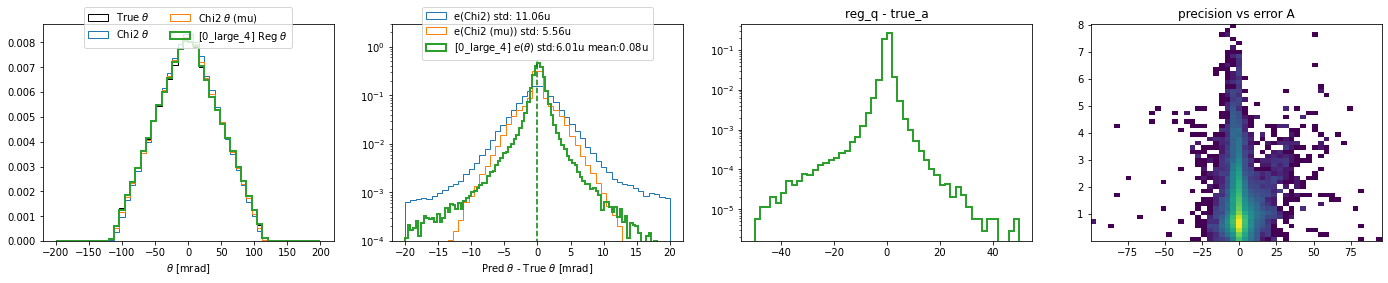

1_medium_dist_4


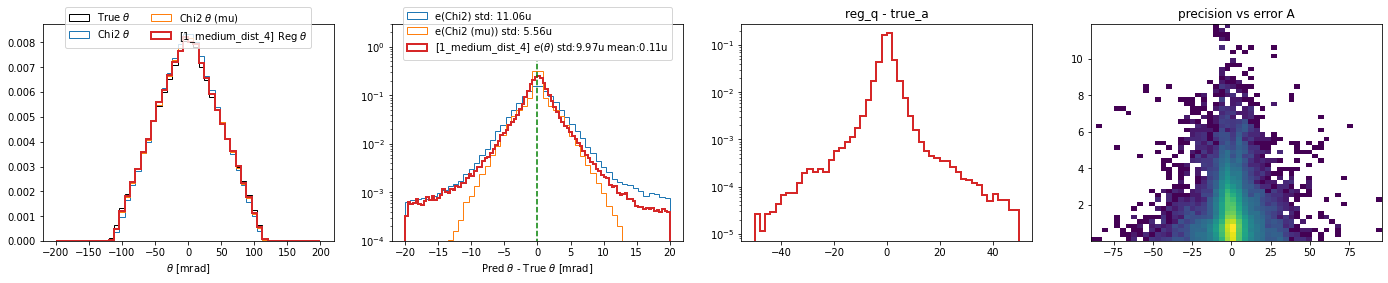

2_small_dist_4


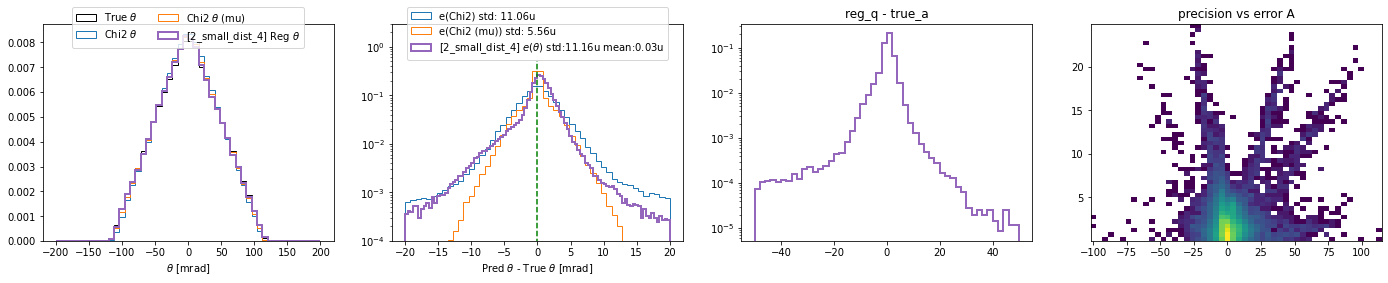

3_medium_5


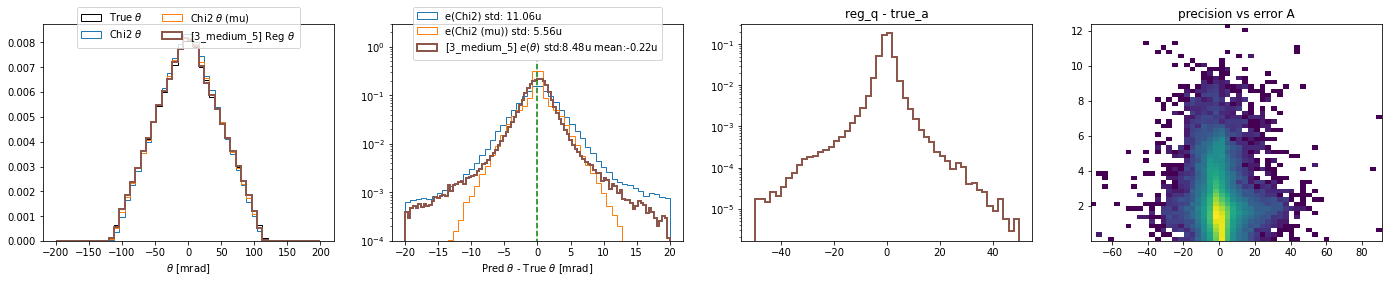

4_small_5


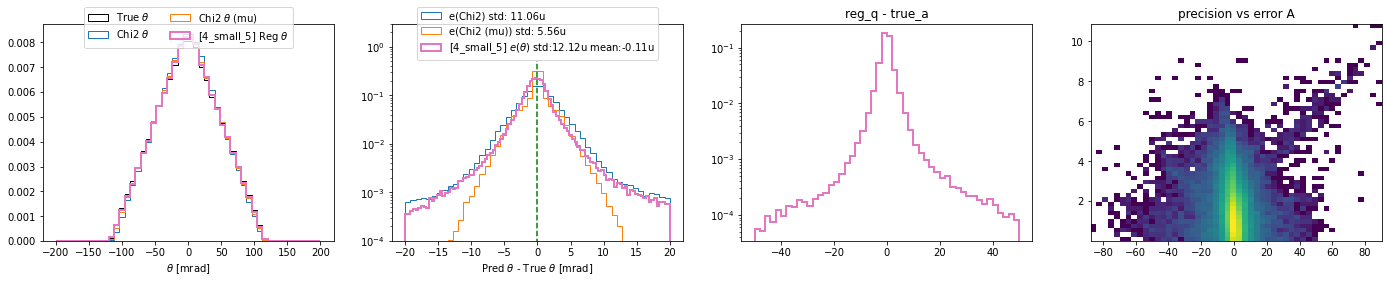

5_medium_6


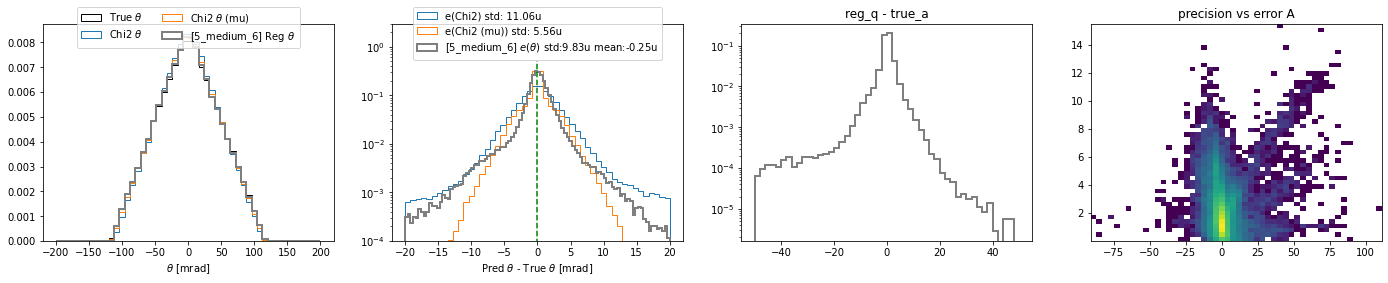

6_small_6


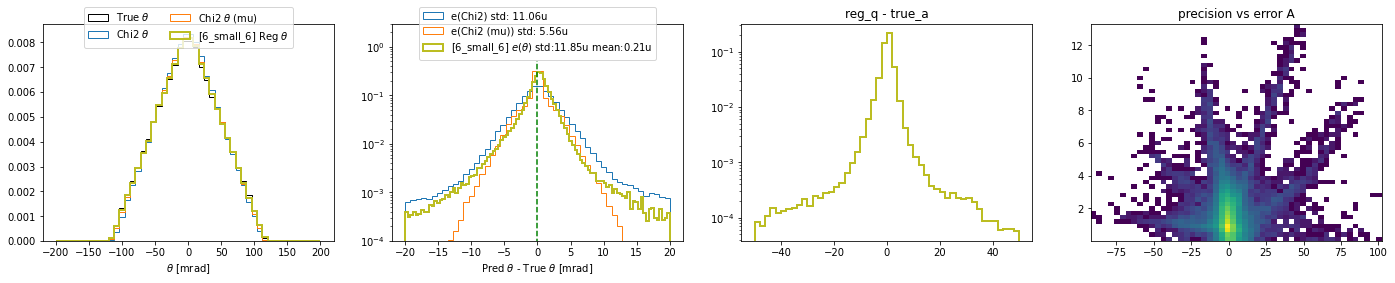

7_small_dist_7


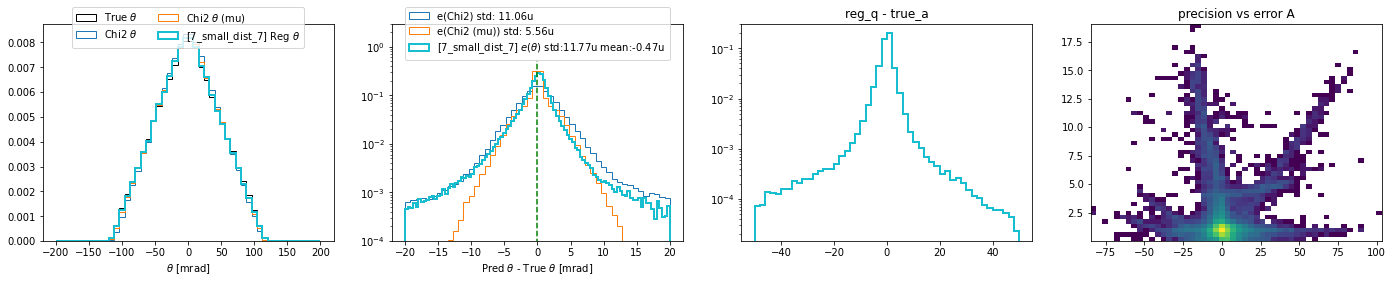

8_large_8


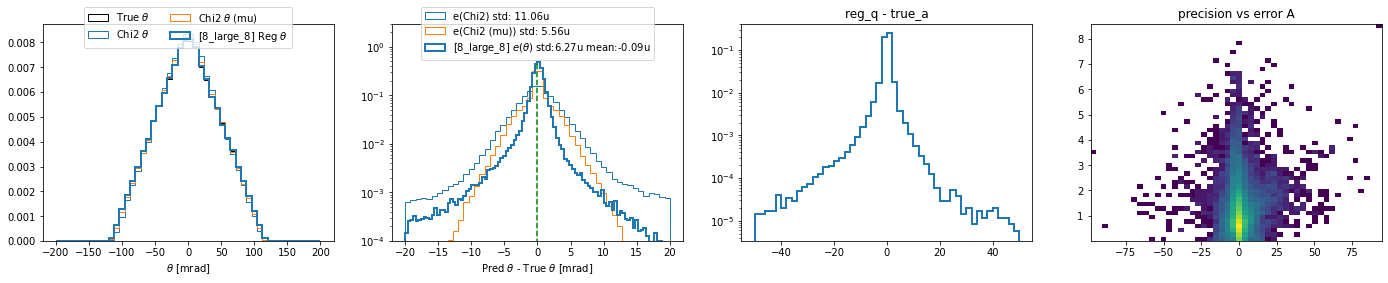

9_run26


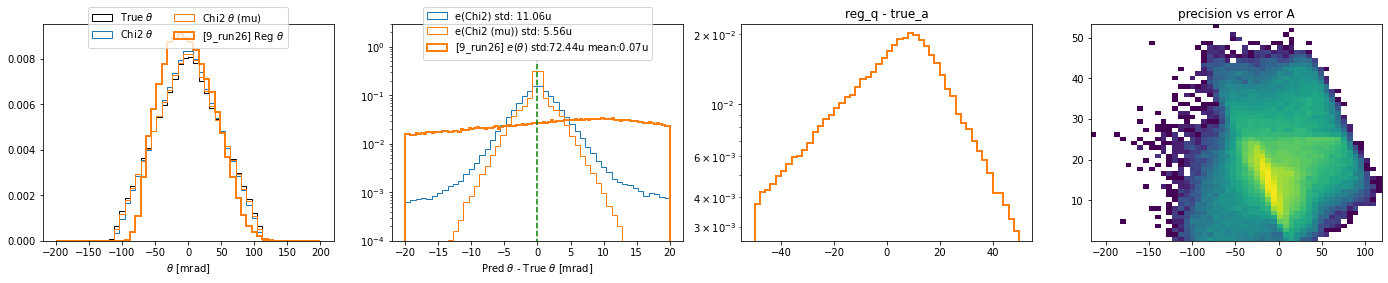

10_run36_large


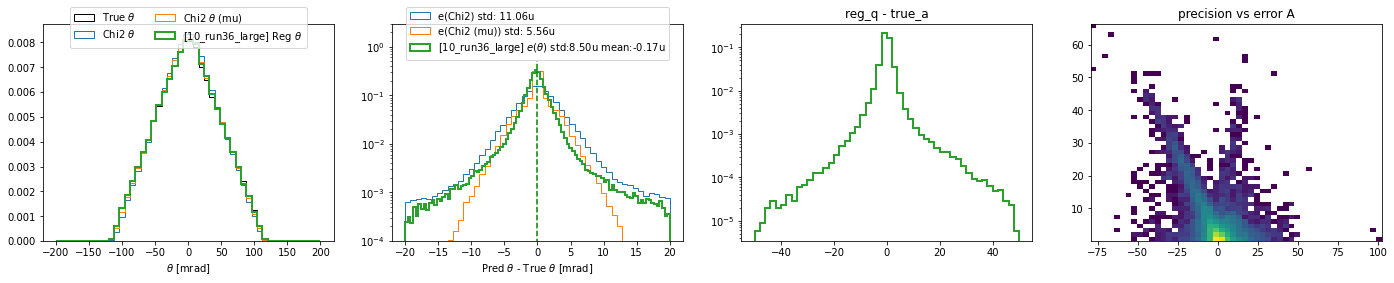

11_run36_medium


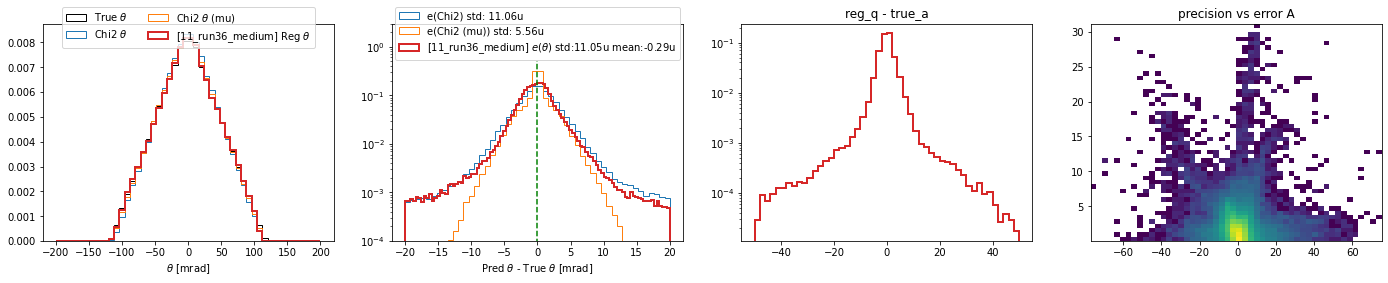

In [22]:
this_cut=(Y_mu==1)

norm_fit_chi2 = stats.norm.fit(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1])
norm_fit_chi2mu = [0,0]#stats.norm.fit(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1])

for mod in mdict:
    print (mod)
    ncols, nrows = (4,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()

    axs[0].hist(data['ev_mu_theta'][this_cut]*1000, histtype='step', range=(-0.2*1000,0.2*1000), density=1, color='black',
                bins=50, label=r'True $\theta$')

    axs[0].hist(lfits_theta[this_cut], histtype='step', range=(-0.2*1000,0.2*1000), density=1, color='C0',
                bins=50, label=r'Chi2 $\theta$')

    axs[0].hist(lfits_mu_theta[this_cut], histtype='step', range=(-0.2*1000,0.2*1000), density=1, color='C1',
                 bins=50, label=r'Chi2 $\theta$ (mu)')
    
    fit_std = (lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000).std()
    axs[1].hist(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C0',
                bins=50, label=f'e(Chi2) std: {(fit_std/norm_a):.2f}u')
                #                bins=50, label=f'Chi2 ( {norm_fit_chi2[0]:.4f}, {norm_fit_chi2[1]:.4f} ) {std_fit}')
    fit_mu_std = (lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000).std()
    axs[1].hist(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C1',
                bins=50, label=f'e(Chi2 (mu)) std: {(fit_mu_std/norm_a):.2f}u')

#    axs[2].hist(lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C0',
#                bins=50, label=f'Chi2')

#    axs[2].hist(lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000, histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C1',
#                bins=50, label=f'Chi2 (mu)')

#    axs[3].hist(lfits_theta[Y_mu==0], histtype='step', range=(-0.2,0.2), density=1, color='C0',
#                 bins=50, label=f'Chi2 Angle')

#    axs[3].hist(lfits_mu_theta[Y_mu==0], histtype='step', range=(-0.2,0.2), density=1, color='C1',
#                 bins=50, label=f'Chi2 Angle (mu)')
        
    if True:
        areg=mdict[mod]['a_reg']
        axs[0].hist(areg[this_cut], histtype='step', range=(-0.2*1000,0.2*1000), bins=50, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}]' + r' Reg $\theta$', linewidth=2)

#        norm_fit_mod = stats.norm.fit(areg[this_cut] - data['ev_mu_theta'][this_cut]*1000)
#        axs[1].hist(areg[this_cut] - data['ev_mu_theta'][this_cut]*1000, 
#                    histtype='step', range=(-0.01*1000,0.01*1000), bins=50, color=mdict[mod]['color'],  density=1,
#                    label=f'[{mod}] Reg Angle ( {norm_fit_mod[0]:.4f}, {norm_fit_mod[1]:.4f} )', linewidth=2)

        this_std = (areg[this_cut] - data['ev_mu_theta'][this_cut]*1000).std()
        a_mean = (areg[this_cut] - data['ev_mu_theta'][this_cut]*1000).mean()
        axs[1].hist(areg[this_cut] - data['ev_mu_theta'][this_cut]*1000, 
                    histtype='step', range=(-0.02*1000,0.02*1000), bins=100, color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}]' + r' $e(\theta)$ ' + f'std:{(this_std/norm_a):.2f}u mean:{(a_mean/norm_a):.2f}u', linewidth=2)
        
        axs[2].hist(areg[this_cut] - data['ev_mu_theta'][this_cut]*1000, 
                    histtype='step', bins=50, range=(-0.05*1000,0.05*1000), color=mdict[mod]['color'],  density=1,
                    label=f'[{mod}]' + r' $\theta$', linewidth=2)

        axs[3].hist2d(
#            data['ev_mu_theta'][this_cut]*1000 - mdict[mod]['a_reg_q'][this_cut],
            data['ev_mu_theta'][this_cut]*1000 - areg[this_cut] ,
            mdict[mod]['a_reg_dq'][this_cut],
#            mdict[mod]['a_reg'][this_cut],
#            mdict[mod]['a_reg_q'][this_cut],
#            range=( (-0.02*1000, 0.02*1000), (-0*1000, 0.5*1000)),
            bins=(50,50),
            norm=mpl.colors.LogNorm()       
        )

    axs[0].set_xlabel(r'$\theta$ [mrad]')
    axs[1].set_xlabel(r'Pred $\theta$ - True $\theta$ [mrad]')
#    axs[2].set_xlabel(r'Pred $\theta$ - True $\theta$ [mrad]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[1].set_ylim([1e-4, 3])
#    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
#    axs[2].set_yscale('log')
    axs[2].set_title(r'reg_q - true_a')
    axs[2].set_yscale('log')
    axs[3].set_title(r'precision vs error A')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    
    axs[1].plot([0,0], [1e-5, 0.5], 'g--')
    # axs[2].plot([0,0], [1e-4, 1e3], 'g--')
    plt.savefig(f'plots/angle_{mod}.pdf')
    plt.show()
    

## X

0_large_4


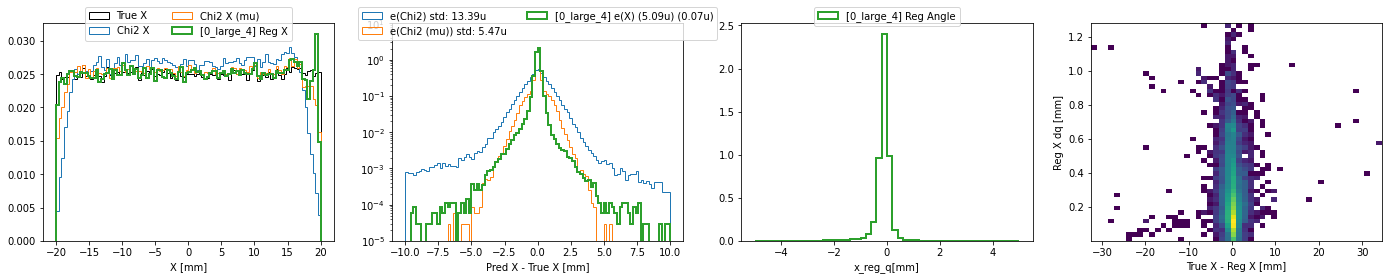

1_medium_dist_4


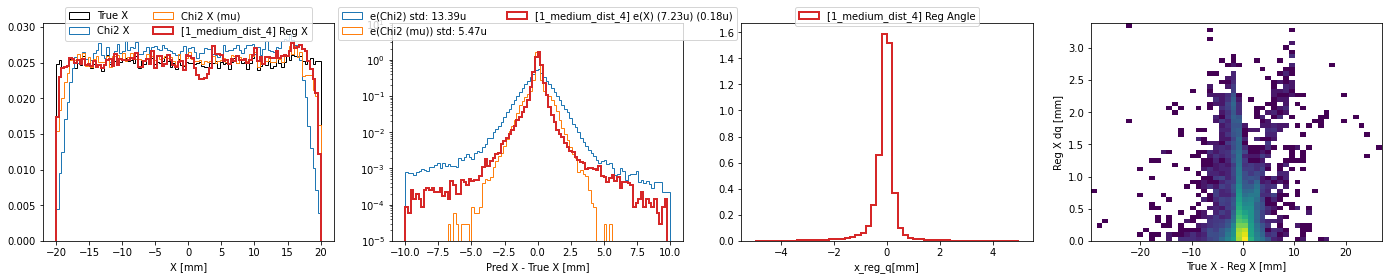

2_small_dist_4


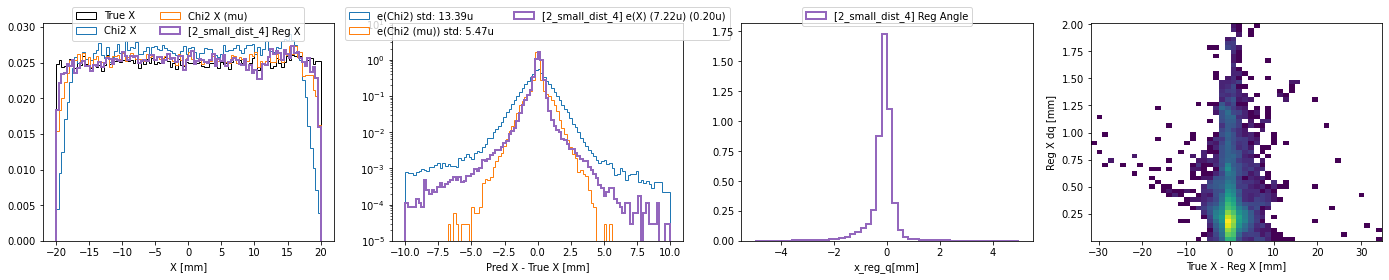

3_medium_5


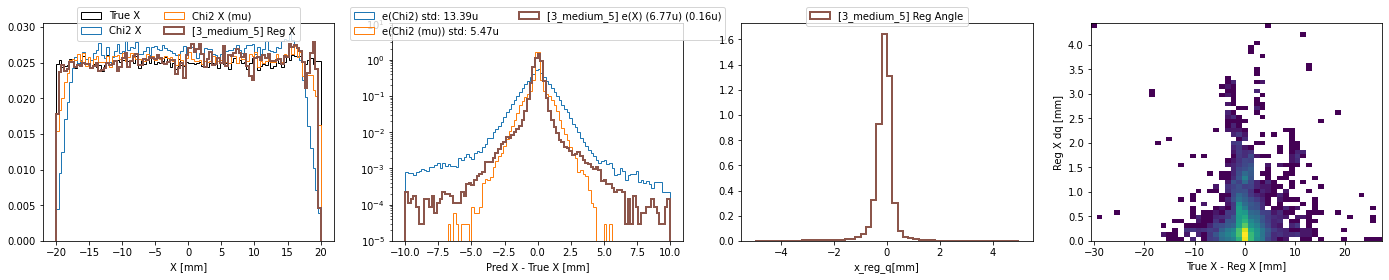

4_small_5


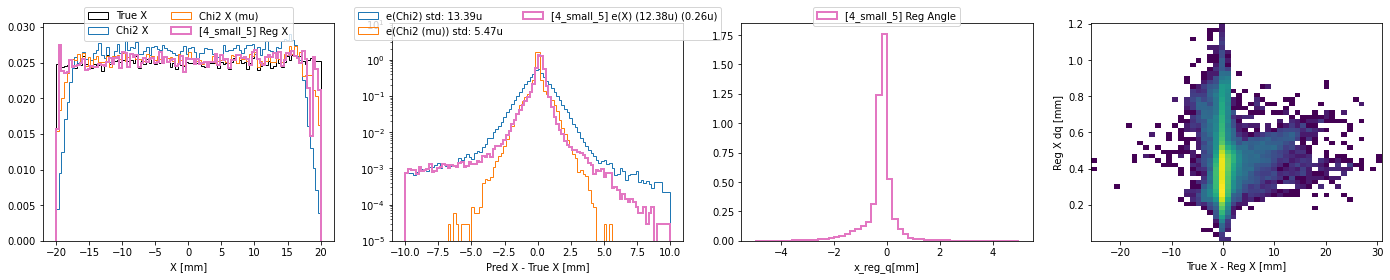

5_medium_6


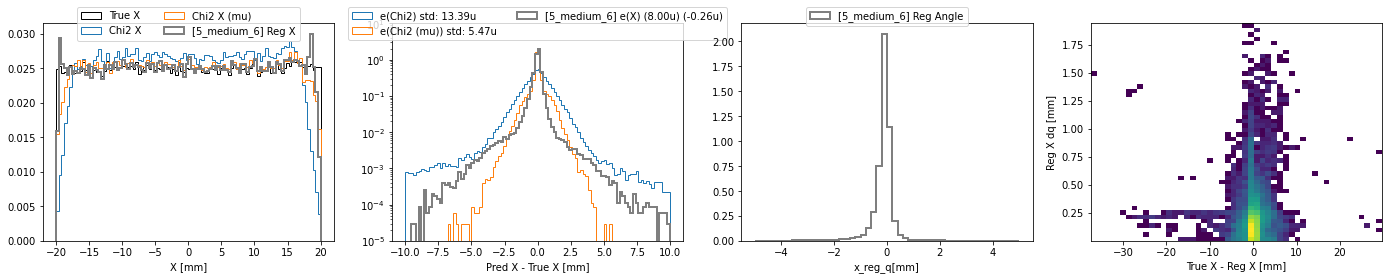

6_small_6


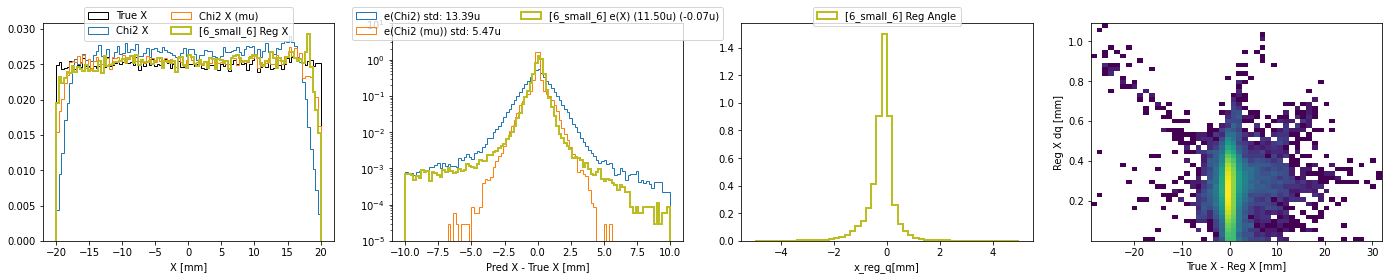

7_small_dist_7


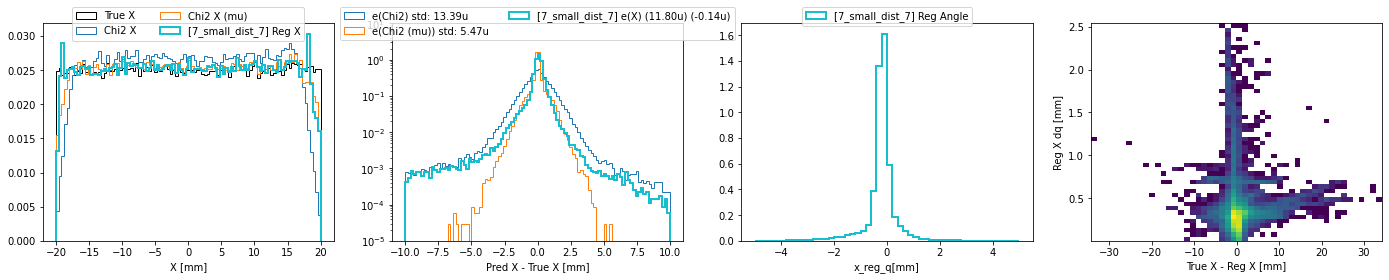

8_large_8


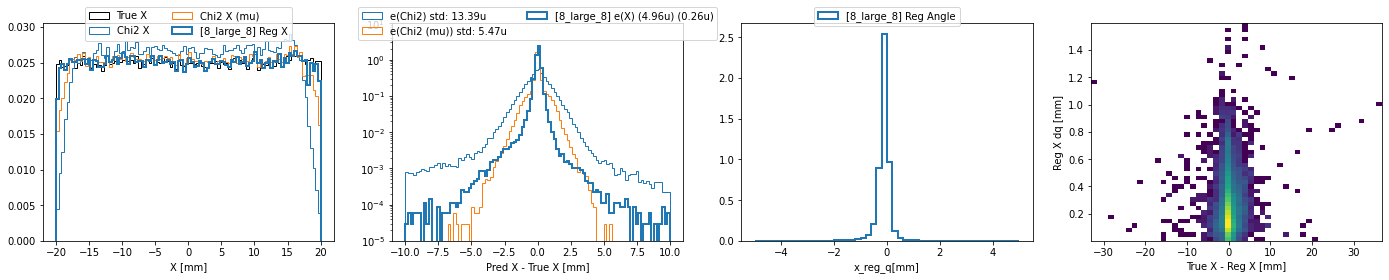

9_run26


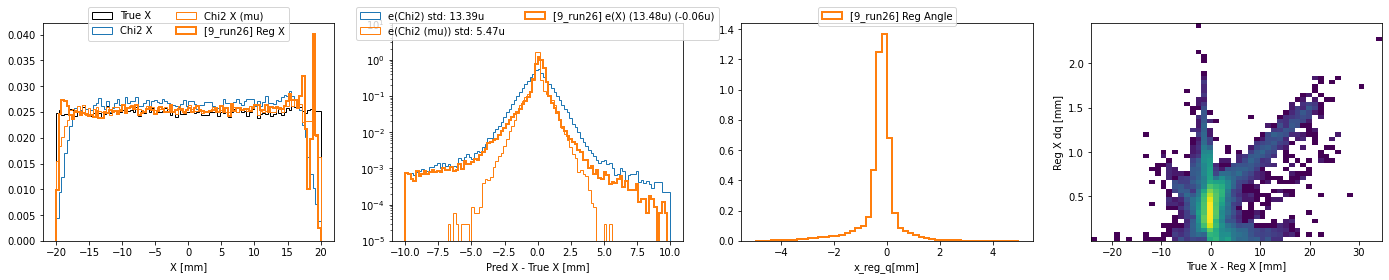

10_run36_large


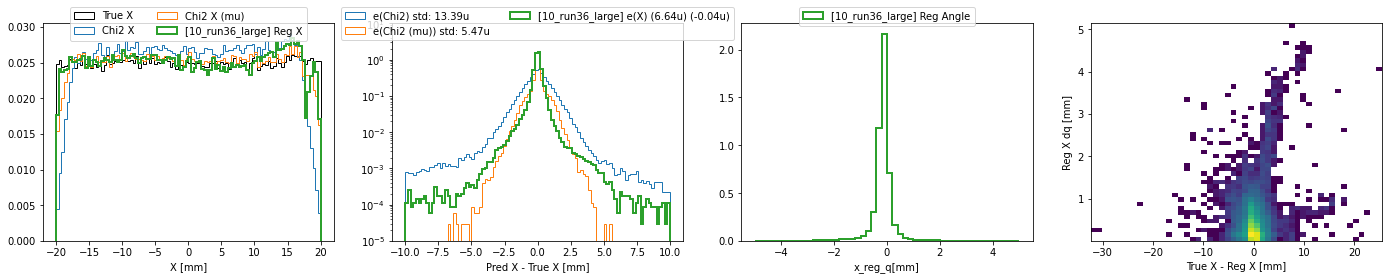

11_run36_medium


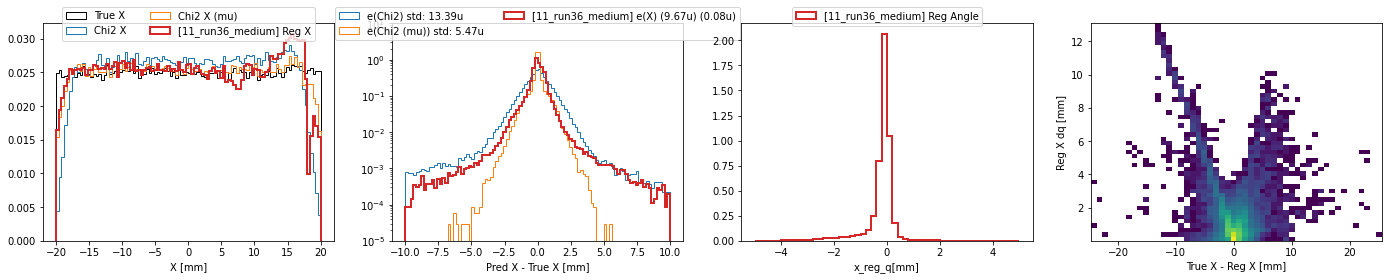

In [23]:
for mod in mdict:

    print (mod)
    ncols, nrows = (4,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()



    this_cut=(Y_mu==1)

    fit_std = (lfits[this_cut][:,1] - data['ev_mu_x'][this_cut]).std()
    fit_mu_std = (lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1]).std()
    axs[0].hist(data['ev_mu_x'][this_cut], histtype='step', range=(-20,20), color='black',density=1,
                bins=100, label=f'True X')

    axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-20,20), color='C0',density=1,
                bins=100, label=f'Chi2 X ')

    axs[0].hist(lfits_mu[this_cut][:,1], histtype='step', range=(-20,20), color='C1',density=1,
                bins=100, label=f'Chi2 X (mu)')

    axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-10,10), color='C0',density=1,
                bins=100, label=f'e(Chi2) std: {(fit_std/norm_x):.2f}u')

    axs[1].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-10,10), color='C1',density=1,
                bins=100, label=f'e(Chi2 (mu)) std: {(fit_mu_std/norm_x):.2f}u')

#    axs[2].hist(lfits[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-2,2), color='C0',
#                bins=100, label=f'Chi2 X')

#    axs[2].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut], histtype='step', range=(-2,2), color='C1',
#                bins=100, label=f'Chi2 X (mu)')

#     axs[3].hist(lfits[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C0',
#                 bins=100, label=f'Chi2 X')

#     axs[3].hist(lfits_mu[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C1',
#                 bins=100, label=f'Chi2 X (mu)')
    
    if 'x_reg' in mdict[mod]:
        
        xreg=mdict[mod]['x_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-20,20), bins=100, color=mdict[mod]['color'], density=1,
                    label=f'[{mod}] Reg X', linewidth=2)
        
##        axs[1].hist(xreg[this_cut] - data['ev_mu_x'][this_cut], 
#                    histtype='step', range=(-10,10), bins=100, color=mdict[mod]['color'], 
#                    label=f'[{mod}] Reg X', linewidth=2)
        
        this_std = (xreg[this_cut] - data['ev_mu_x'][this_cut]).std()
        x_mean = (xreg[this_cut] - data['ev_mu_x'][this_cut]).mean()
        axs[1].hist(
            xreg[this_cut] - data['ev_mu_x'][this_cut], 
            histtype='step', 
            range=(-10,10), 
            bins=100, color=mdict[mod]['color'], density=1,
            label=f'[{mod}] e(X) ({(this_std/norm_x):.2f}u) ({(x_mean/norm_x):.2f}u)', linewidth=2)
        
        axs[2].hist(
            mdict[mod]['x_reg_q'][this_cut]  - data['ev_mu_x'][this_cut], 
            histtype='step', 
            range=(-5,5), 
            bins=50, color=mdict[mod]['color'],  density=1,
            label=f'[{mod}] Reg Angle', linewidth=2)
        axs[2].set_xlabel('x_reg_q[mm]')
        
        axs[3].hist2d(
#            data['ev_mu_x'][this_cut],
            data['ev_mu_x'][this_cut] - xreg[this_cut],
            mdict[mod]['x_reg_dq'][this_cut],
#            range=( (-20, 20), (-20, 20)),
            bins=(50,50),
            norm=mpl.colors.LogNorm())
        axs[3].set_xlabel('True X - Reg X [mm]')
        axs[3].set_ylabel('Reg X dq [mm]')
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[1].set_ylim([1e-5, 10])
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
#    axs[1].plot([-5,5], [1e-5, 20], 'g--')
#    axs[3].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    plt.savefig(f'plots/x_{mod}.pdf')
    plt.show()
    

In [24]:
for mod in mdict:
    if 'y_reg' not in mdict[mod]:
        continue

    ncols, nrows = (4,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()



    this_cut=(Y_mu==1)


    axs[0].hist(data['ev_mu_y'][this_cut], histtype='step', range=(-40,40), color='black',
                bins=100, label=f'True Y')

    # axs[0].hist(lfits[this_cut][:,1], histtype='step', range=(-40,40), color='C0',
    #             bins=100, label=f'Chi2 Y')

    # axs[0].hist(lfits_mu[this_cut][:,1], histtype='step', range=(-40,40), color='C1',
    #             bins=100, label=f'Chi2 X (mu)')

    # axs[1].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C0',
    #             bins=100, label=f'Chi2 X')

    # axs[1].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-10,10), color='C1',
    #             bins=100, label=f'Chi2 X (mu)')

    # axs[2].hist(lfits[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C0',
    #             bins=100, label=f'Chi2 X')

    # axs[2].hist(lfits_mu[this_cut][:,1] - data['ev_mu_x'][Y_mu==1], histtype='step', range=(-2,2), color='C1',
    #             bins=100, label=f'Chi2 X (mu)')

    # axs[3].hist(lfits[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C0',
    #             bins=100, label=f'Chi2 X')

    # axs[3].hist(lfits_mu[Y_mu==0][:,1], histtype='step', range=(-200,40), color='C1',
    #             bins=100, label=f'Chi2 X (mu)')
    
    if 'y_reg' in mdict[mod]:
        
        xreg=mdict[mod]['y_reg']
        axs[0].hist(xreg[this_cut], histtype='step', range=(-40,40), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        axs[1].hist(xreg[this_cut] - data['ev_mu_y'][Y_mu==1], 
                    histtype='step', range=(-10,10), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X', linewidth=2)
        
        this_std = (xreg[this_cut] - data['ev_mu_y'][Y_mu==1]).std()
        axs[2].hist(xreg[this_cut] - data['ev_mu_y'][Y_mu==1], 
                    histtype='step', range=(-2,2), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg X ({this_std:.3f})', linewidth=2)
        
        axs[3].hist(xreg[Y_mu==0], 
                    histtype='step', range=(-200,40), bins=100, color=mdict[mod]['color'], 
                    label=f'[{mod}] Reg Y', linewidth=2)
        
        
    axs[0].set_xlabel('X [mm]')
    axs[1].set_xlabel('Pred X - True X [mm]')
    axs[2].set_xlabel('Pred X - True X [mm]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].set_yscale('log')
    axs[2].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[2].set_yscale('log')
    # plt.savefig(f"plots/{mod}_reg_0.pdf")
    plt.show()

## mix

mod: 0_large_4: loss: 0.009820128791034222


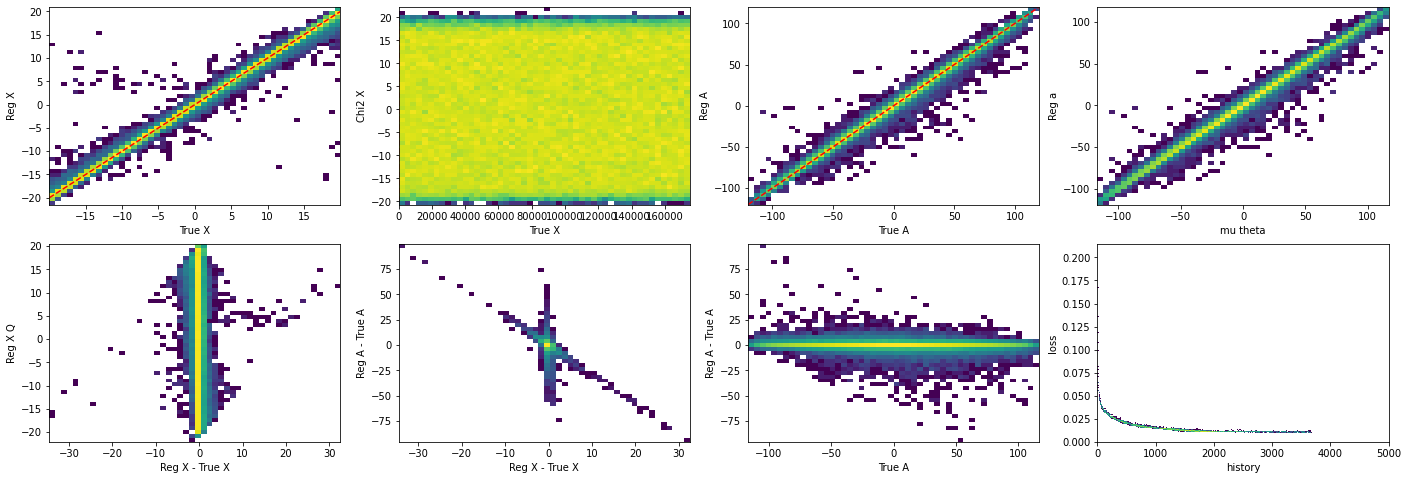

mod: 1_medium_dist_4: loss: 0.014209035784006119


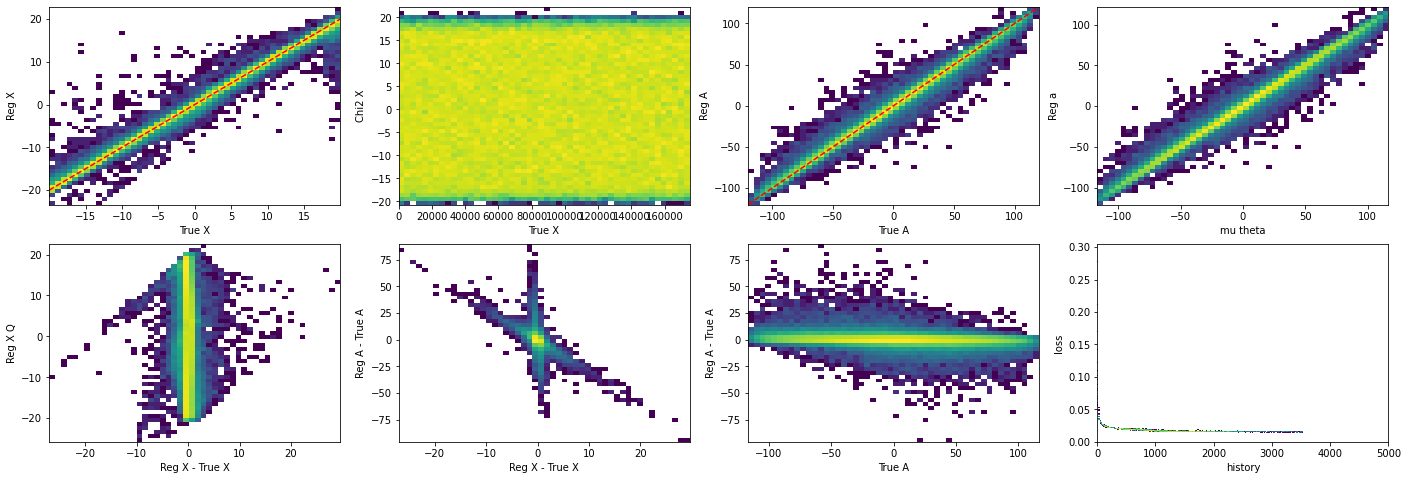

mod: 2_small_dist_4: loss: 0.014372631907463074


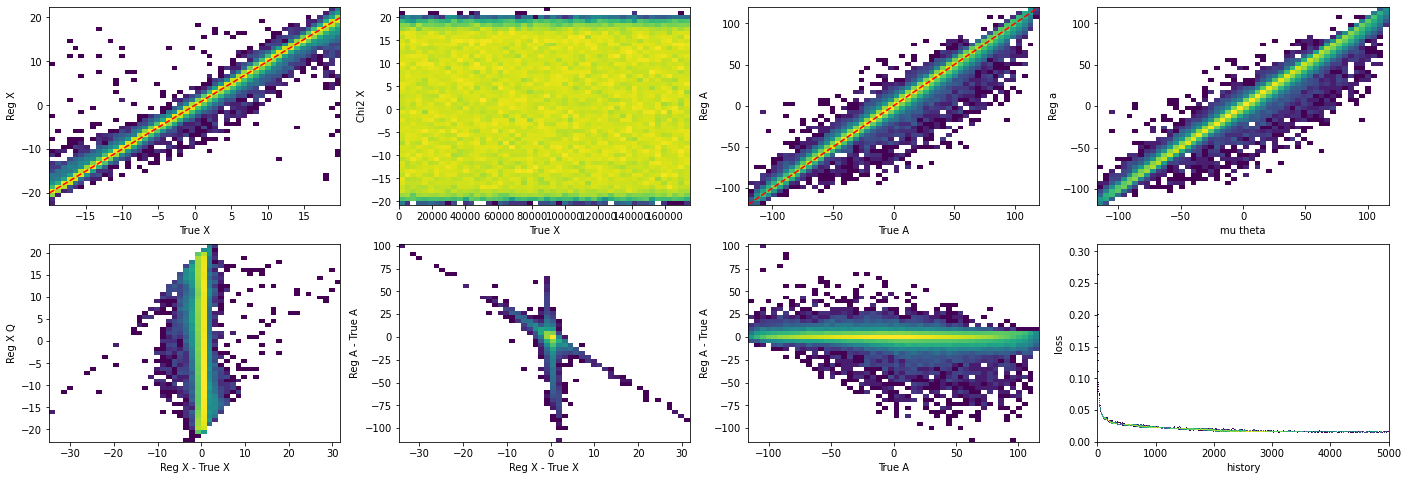

mod: 3_medium_5: loss: 0.01734471693634987


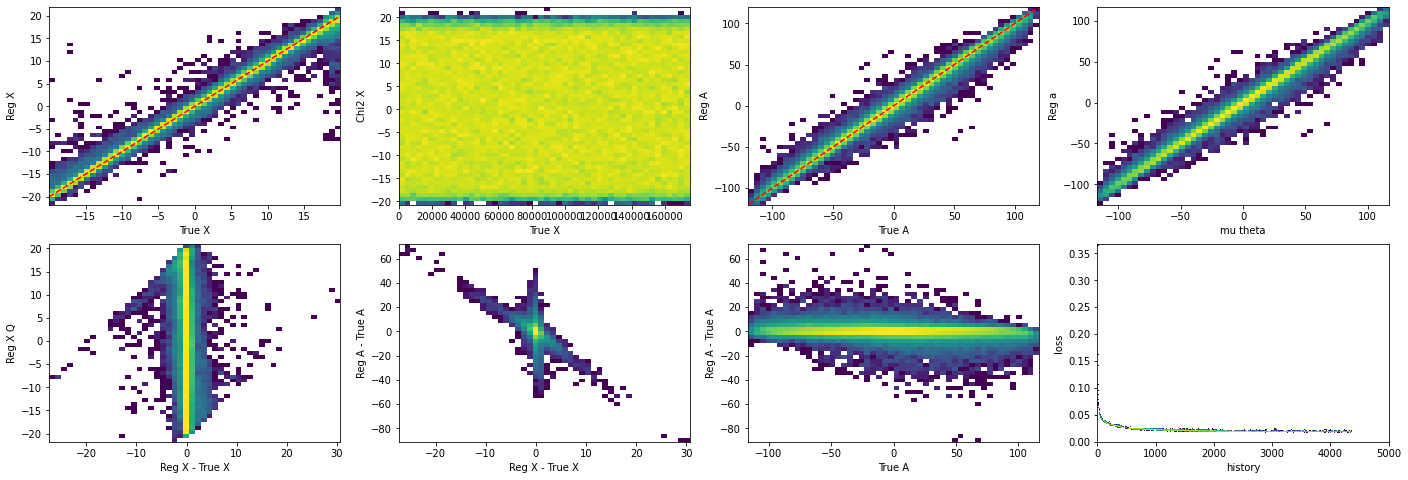

mod: 4_small_5: loss: 0.022263092920184135


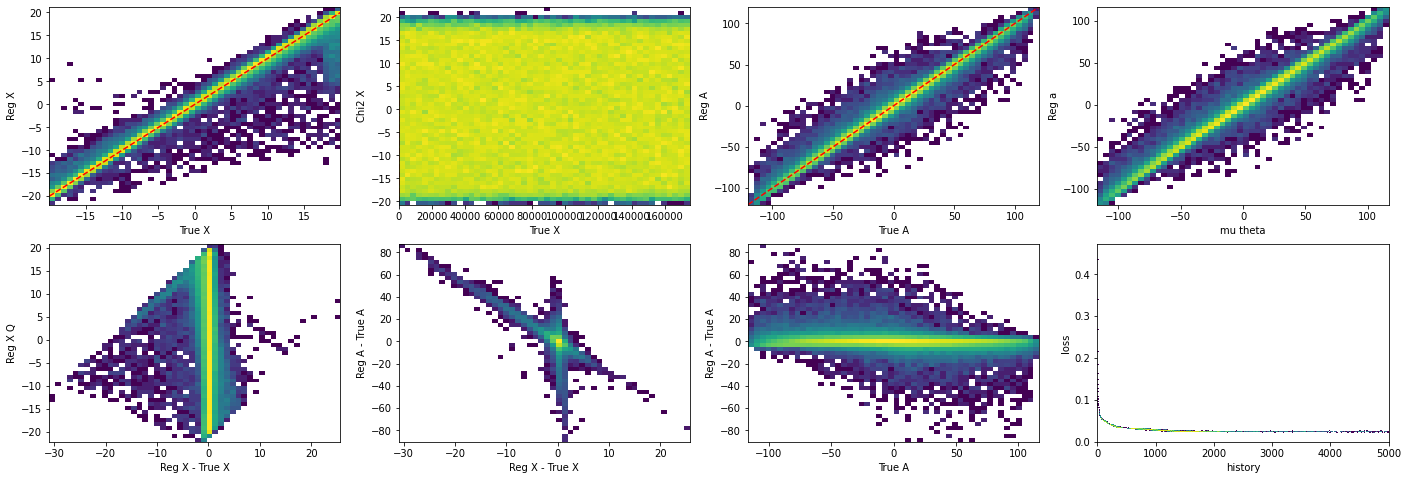

mod: 5_medium_6: loss: 0.01610731892287731


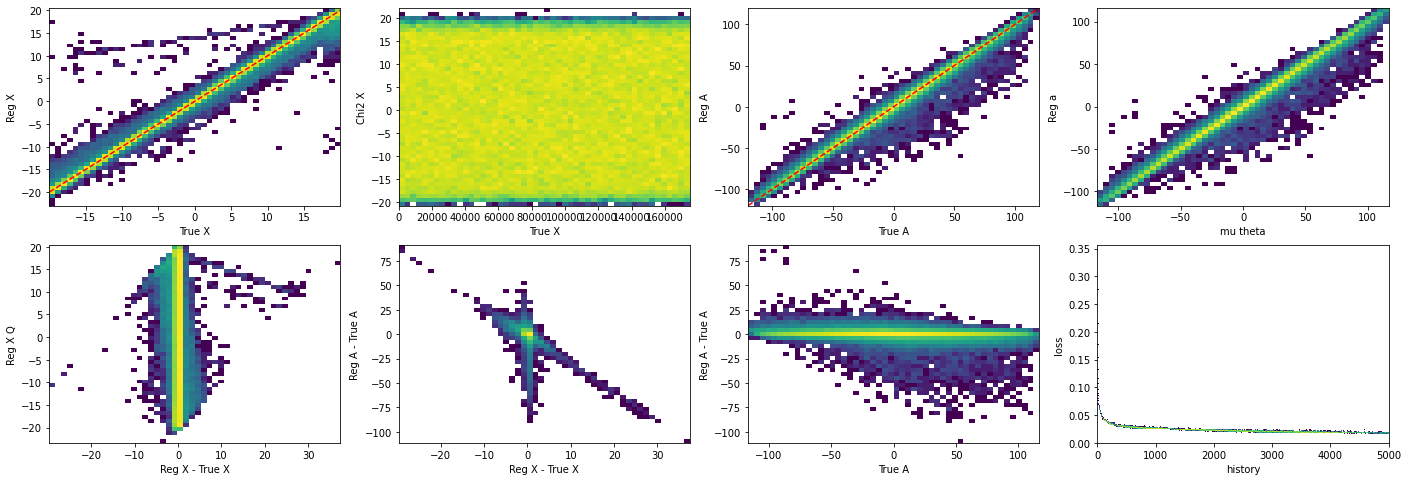

mod: 6_small_6: loss: 0.019457640126347542


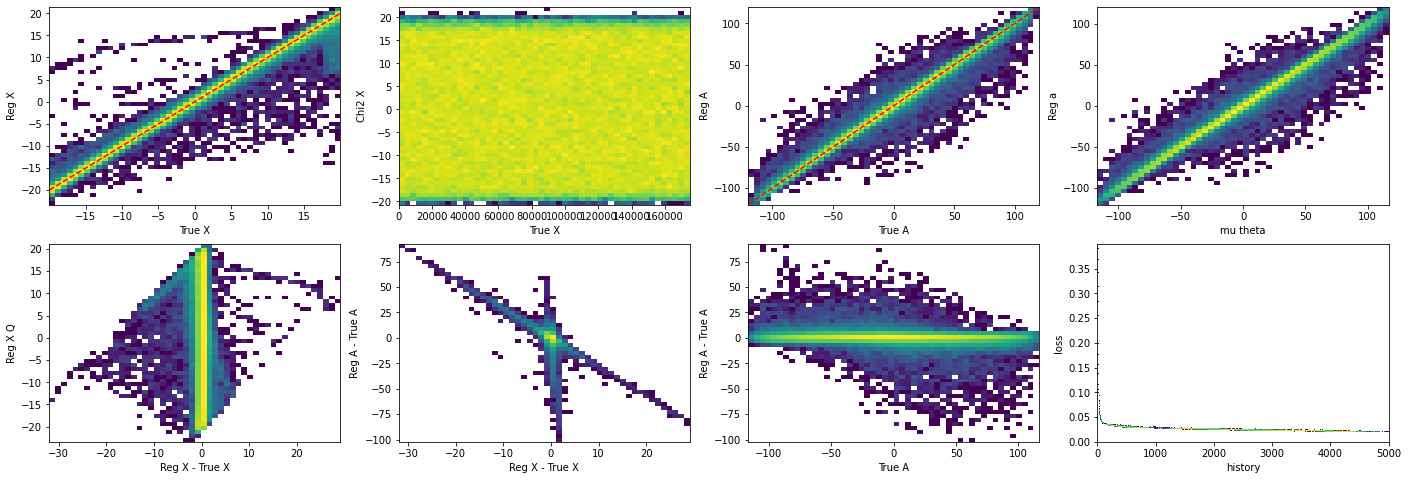

mod: 7_small_dist_7: loss: 0.019320525228977203


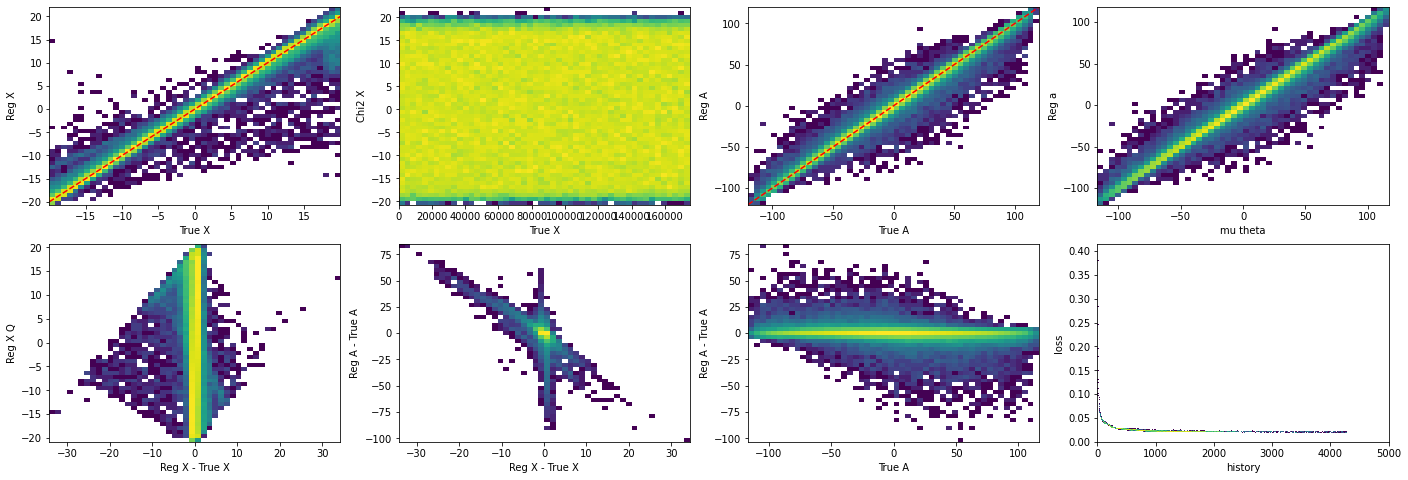

mod: 8_large_8: loss: 0.00973188504576683


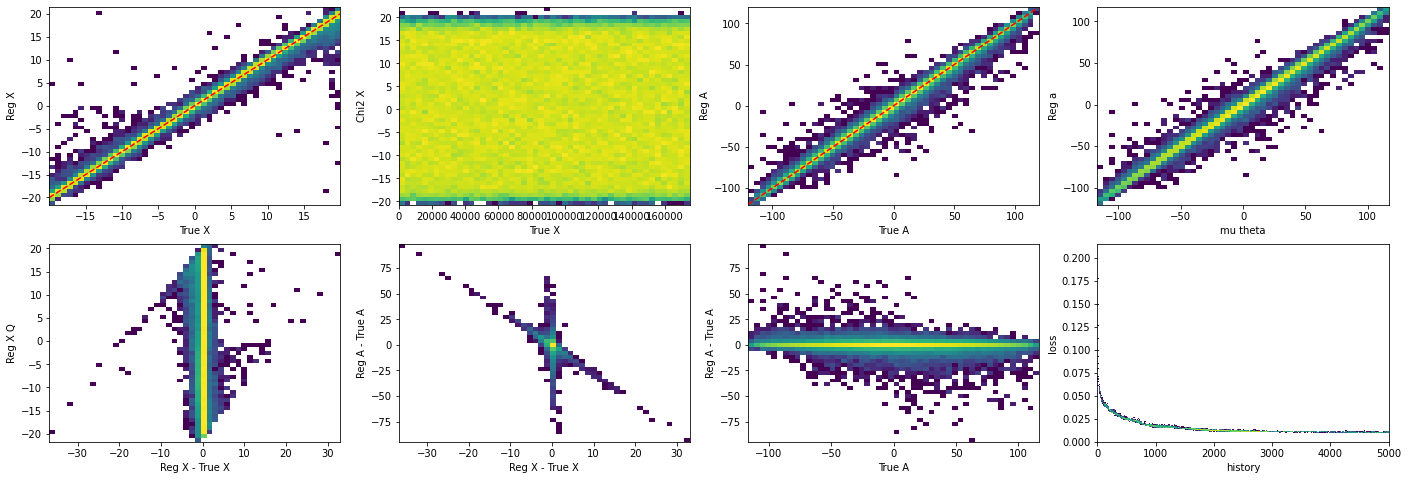

mod: 9_run26: loss: 0.11714804172515869


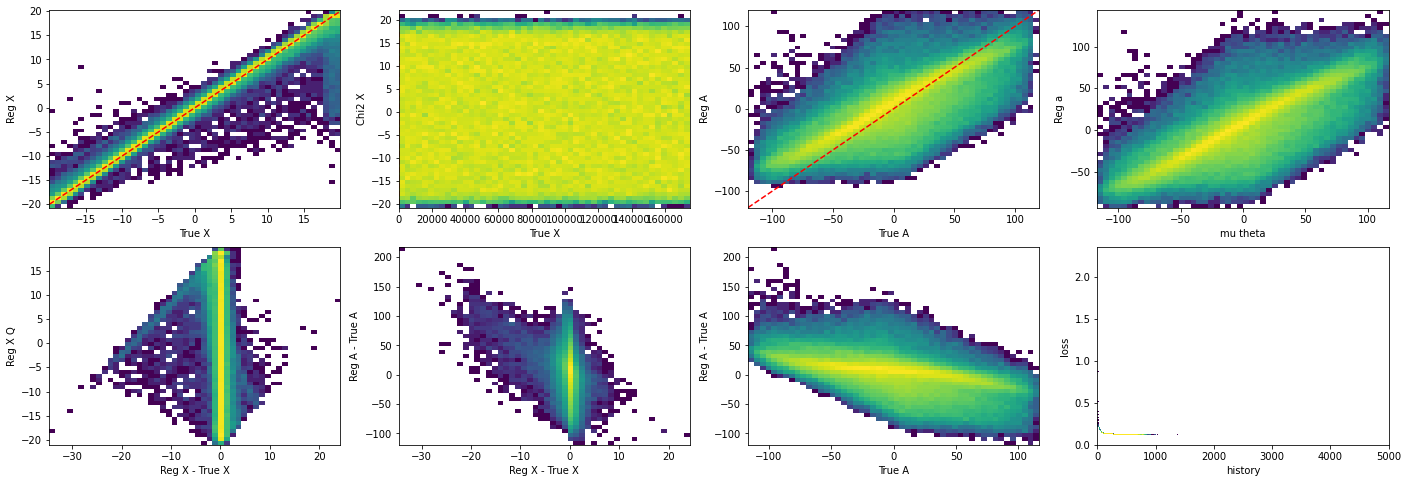

mod: 10_run36_large: loss: 0.012559641152620316


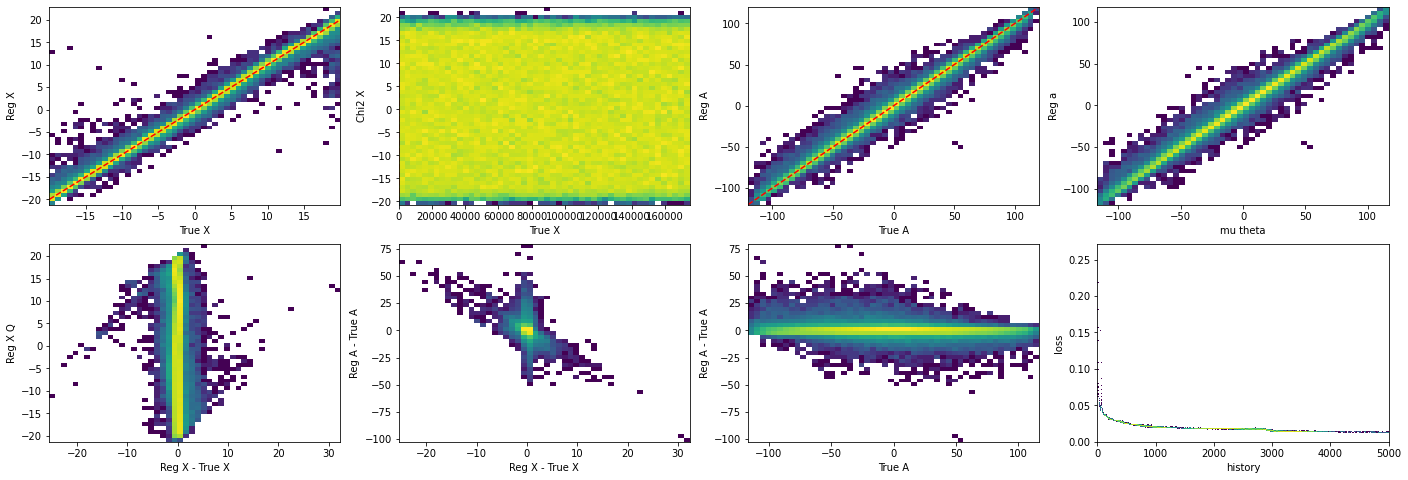

mod: 11_run36_medium: loss: 0.019370974972844124


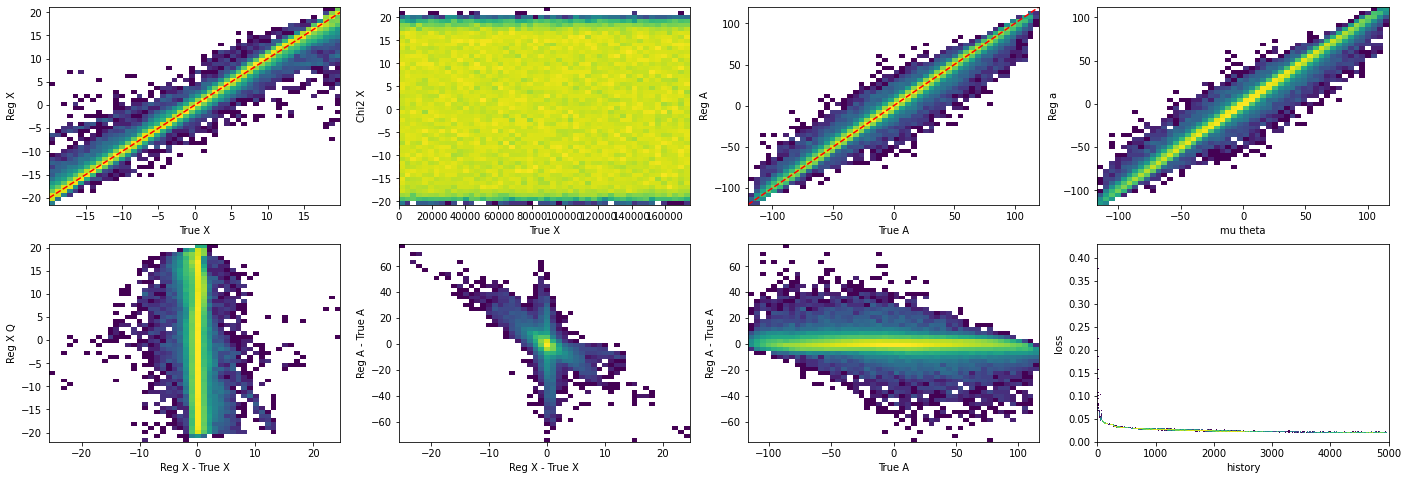

In [25]:
for mod in mdict:
    print (f"mod: {mod}: loss: {min(mdict[mod]['history'])}")
    ncols, nrows = (4,2)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()

    
    this_cut=(Y_mu==1)
    
    axs[0].hist2d( 
        data['ev_mu_x'][this_cut], 
        mdict[mod]['x_reg'][this_cut], 
#        range=((-20,20),(-20,20)),
        bins=(50,50),norm=mpl.colors.LogNorm())
    axs[0].set_xlabel('True X')
    axs[0].set_ylabel('Reg X')
    axs[0].plot([-20,20],[-20,20], 'r--')
    
    axs[1].hist2d( 
range(len(         lfits[this_cut][:,1])),
    #data['ev_mu_x'][this_cut], 
        lfits[this_cut][:,1], 
#       range=((-20,20),(-20,20)),
        bins=(50,50),norm=mpl.colors.LogNorm())
    axs[1].set_xlabel('True X')
    axs[1].set_ylabel('Chi2 X')
    axs[1].plot([-20,20],[-20,20], 'r--')
    
    axs[2].hist2d( 
        data['ev_mu_theta'][this_cut]*1000, 
        mdict[mod]['a_reg'][this_cut], 
        range=((-120,120),(-120,120)),
        bins=(50,50),norm=mpl.colors.LogNorm())
    axs[2].set_xlabel('True A')
    axs[2].set_ylabel('Reg A')
    axs[2].plot([-120,120],[-120,120], 'r--')
    
    axs[3].hist2d(data['ev_mu_theta'][this_cut]*1000, 
                  mdict[mod]['a_reg'][this_cut],
#                  range=((-120,120), (-120,120)),
                bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[3].set_xlabel('mu theta')
    axs[3].set_ylabel('Reg a')
    
    axs[4].hist2d(
#        data['ev_mu_x'][this_cut], 
        mdict[mod]['x_reg'][this_cut]- data['ev_mu_x'][this_cut], 
        mdict[mod]['x_reg_q'][this_cut], 
#        range=((-0.15, 0.15), (-1,1)),
        bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[4].set_xlabel('Reg X - True X')
    axs[4].set_ylabel('Reg X Q')
    
    axs[5].hist2d(
        mdict[mod]['x_reg'][this_cut]- data['ev_mu_x'][this_cut], 
        mdict[mod]['a_reg'][this_cut] - data['ev_mu_theta'][this_cut]*1000, 
        bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[5].set_xlabel('Reg X - True X')
    axs[5].set_ylabel('Reg A - True A')
        
    axs[6].hist2d(
        data['ev_mu_theta'][this_cut]*1000, 
        mdict[mod]['a_reg'][this_cut] - data['ev_mu_theta'][this_cut]*1000, 
#        mdict[mod]['a_reg_q'][this_cut], 
#        range=((-125,125), (-150,150)),
        bins=(50,50),norm=mpl.colors.LogNorm() )
    axs[6].set_xlabel('True A')
    axs[6].set_ylabel('Reg A - True A')

#    print(mdict[mod]['history'])
#    print(range(len( mdict[mod]['a_reg'][this_cut])))
    
    axs[7].hist2d(
        range(len( mdict[mod]['history'])), 
        mdict[mod]['history'],
#        mdict[mod]['a_reg'][this_cut], 
        range=((0,5000), (0,mdict[mod]['history'][-1]*20)),
        
        bins=(250,250),norm=mpl.colors.LogNorm() 
    )
    axs[7].set_xlabel('history')
    axs[7].set_ylabel('loss')

#    plt.savefig(f"plots/{mod}_reg_2d.pdf")
    plt.show()

single plots

In [26]:
def plot_mymodel(mod_name="none"): 
    x_true = data['ev_mu_x'][this_cut]
    x_keras = mdict[mod_name]['x_reg'][Y_mu==1]
    a_true = data['ev_mu_theta'][Y_mu==1]*1000
    a_keras = mdict[mod_name]['a_reg'][Y_mu==1]
    ncols, nrows = (2,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()
    fit_x_std = (lfits[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)].std()
    axs[0].hist((lfits[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)], histtype='step', range=(-10,10), color='C0',density=1,
                    bins=100, label=r'$\chi^2$: $\mu \approx 0$ ' +f'std={(fit_x_std/norm_x):.2f}u')
    fit_mu_x_std = (lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)].std()
    axs[0].hist((lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)], histtype='step', range=(-10,10), color='C1',density=1,
                    bins=100, label=r'$\chi^2_{\mu}$: $\mu \approx 0$ ' +f'std={(fit_mu_x_std/norm_x):.2f}u')
    #print(f"mse x: {mean_squared_error(x_true[this_cut], x_hls[this_cut])}")
    print(f"mse x: {mean_squared_error(x_true, x_keras)},mse a: {mean_squared_error(a_true, a_keras )}")
    x_std_keras = ((x_keras- x_true)).std()
    x_mean_keras = ((x_keras- x_true)).mean()
    axs[0].hist((x_keras - x_true), histtype='step', range=(-10,10),
                bins=100, color='red', density=1,
                        label=r'$NN$: $\mu$=' + f'{(x_mean_keras/norm_x):.2f}u std={(x_std_keras/norm_x):.2f}u', linewidth=2)


    fit_theta_std = (lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000).std()
    axs[1].hist((lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000)[:len(a_true)], histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C0',
                    bins=50, label=r'$\chi^2$: $\mu \approx 0$ ' +f'std={(fit_theta_std/norm_a):.2f}u')
                    #                bins=50, label=f'Chi2 ( {norm_fit_chi2[0]:.4f}, {norm_fit_chi2[1]:.4f} ) {std_fit}')
    fit_thetha_mu_std = (lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000).std()
    axs[1].hist((lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000)[:len(a_true)], histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C1',
                    bins=50, label=r'$\chi^2_{\mu}$: $\mu \approx 0$ ' +f'std={(fit_thetha_mu_std/norm_a):.2f}u')
    #print(f"mse a: {mean_squared_error(a_true[this_cut], a_hls[this_cut]*mult_facta*1000)}")
    a_std_keras = ((a_keras - a_true)).std()
    a_mean_keras = ((a_keras - a_true)).mean()
    axs[1].hist((a_keras - a_true), 
                        histtype='step', range=(-20,20), 
                bins=100, color='red', density=1,
                        label=r'$NN$: $\mu$=' + f'{(a_mean_keras/norm_a):.2f}u std={(a_std_keras/norm_a):.2f}u', linewidth=2)


    axs[0].set_xlabel('Pred X - True X [mm]')
    axs[1].set_xlabel(r'Pred $\theta$ - True $\theta$ [mrad]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[0].set_ylim([1e-5, 10])
    axs[1].set_ylim([1e-5, 10])
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    name=mdict[mod_name]['loc'].split("models/")[1].split("_IB")[0]
    plt.suptitle(f'{name}')
    plt.savefig(f'plots/{mod_name}_{name}x_n_a.pdf')

mse x: 0.2692896759265709,mse a: 6.670810307411831
mse x: 0.47688029776442,mse a: 13.313270308438588
mse x: 1.5943484020724448,mse a: 27.179769718847673


KeyError: '10_run25'

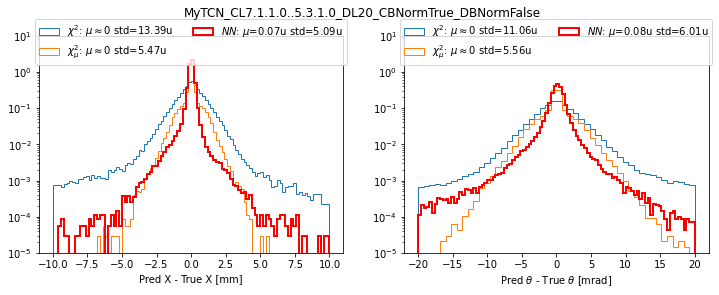

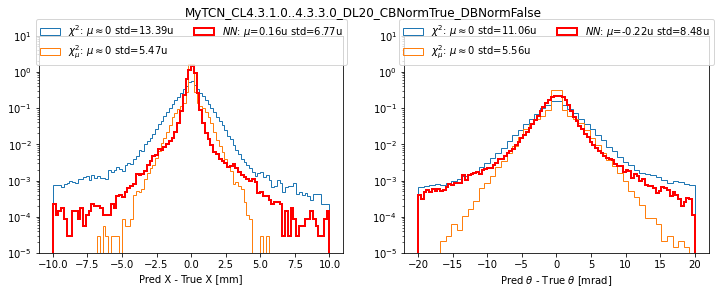

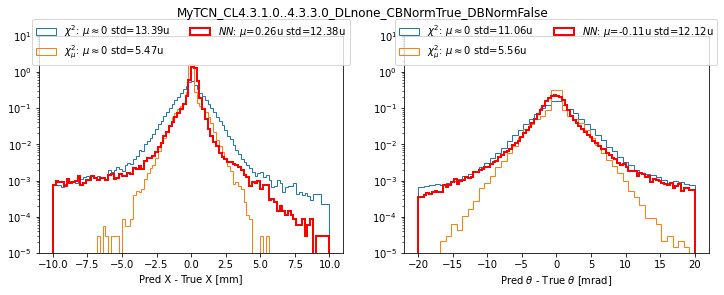

In [27]:
models_to_print=["0_large_4", "3_medium_5", "4_small_5", "10_run25", "17_run31_qkeras"]
for model in models_to_print:
    plot_mymodel(model)

In [ ]:
# plot weights per layer for with and without l2 in training

In [ ]:
# plot weight per layer when including batch normalization

In [ ]:
# compute the quantile of the output at 68%

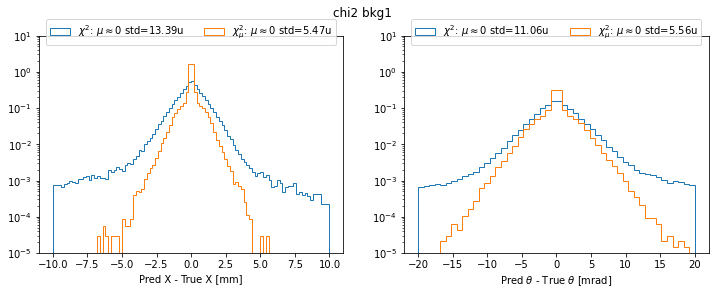

In [28]:
def plot_chi2(): 
    x_true = data['ev_mu_x'][this_cut]
    a_true = data['ev_mu_theta'][Y_mu==1]*1000
    ncols, nrows = (2,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()
    fit_x_std = (lfits[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)].std()
    axs[0].hist((lfits[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)], histtype='step', range=(-10,10), color='C0',density=1,
                    bins=100, label=r'$\chi^2$: $\mu \approx 0$ ' +f'std={(fit_x_std/norm_x):.2f}u')
    fit_mu_x_std = (lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)].std()
    axs[0].hist((lfits_mu[this_cut][:,1] - data['ev_mu_x'][this_cut])[:len(a_true)], histtype='step', range=(-10,10), color='C1',density=1,
                    bins=100, label=r'$\chi^2_{\mu}$: $\mu \approx 0$ ' +f'std={(fit_mu_x_std/norm_x):.2f}u')
    #print(f"mse x: {mean_squared_error(x_true[this_cut], x_hls[this_cut])}")


    fit_theta_std = (lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000).std()
    axs[1].hist((lfits_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000)[:len(a_true)], histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C0',
                    bins=50, label=r'$\chi^2$: $\mu \approx 0$ ' +f'std={(fit_theta_std/norm_a):.2f}u')
                    #                bins=50, label=f'Chi2 ( {norm_fit_chi2[0]:.4f}, {norm_fit_chi2[1]:.4f} ) {std_fit}')
    fit_thetha_mu_std = (lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000).std()
    axs[1].hist((lfits_mu_theta[this_cut] - data['ev_mu_theta'][Y_mu==1]*1000)[:len(a_true)], histtype='step', range=(-0.02*1000,0.02*1000), density=1, color='C1',
                    bins=50, label=r'$\chi^2_{\mu}$: $\mu \approx 0$ ' +f'std={(fit_thetha_mu_std/norm_a):.2f}u')
    #print(f"mse a: {mean_squared_error(a_true[this_cut], a_hls[this_cut]*mult_facta*1000)}")
 
    axs[0].set_xlabel('Pred X - True X [mm]')
    axs[1].set_xlabel(r'Pred $\theta$ - True $\theta$ [mrad]')
    axs[0].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    axs[0].set_ylim([1e-5, 10])
    axs[1].set_ylim([1e-5, 10])
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    plt.suptitle(f'chi2 bkg{config.BKGR}')
    plt.savefig(f'plots/chi2_bkg{config.BKGR}.pdf')
plot_chi2()